## Building a simple statistical model to assess case study viability and assist callibration

### Questions:
* Do these commodity pathways explain the observed introductions?
* How prominent do we expect bridgehead introductions to be?
* How to expect to weight establishment vs. entry?


In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import os
import glob
import geopandas as gpd
from functools import reduce

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# GLM 
import statsmodels.api as sm
from patsy import dmatrices
from sklearn.preprocessing import MinMaxScaler

# Random Forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.inspection import permutation_importance

In [2]:
google_root = 'Q:'
model_name = "ToBRFV_model" # Options: "slf_model", "mln_model", "ToBRFV_model"

data_path = f'{google_root}/Shared drives/Pandemic Data/{model_name}/'

# Path to formatted model inputs
if model_name == "slf_model":
    input_dir = data_path + "inputs/noTWN/"
else:
    input_dir = data_path + "inputs/"

# Path to save outputs
out_dir = data_path + "outputs/"

In [ ]:
# Read in the data and create a simplest format - csv by country
countries_gdf = gpd.read_file(glob.glob(input_dir + "countries*.gpkg")[0])

# Validation data
validation = pd.read_csv(glob.glob(input_dir +'*first_records_validation.csv')[0])

# Origin data
origins = pd.read_csv(input_dir + 'origin_locations.csv')


In [ ]:
# Binary of origins
countries_gdf.loc[countries_gdf['ISO3'].isin(origins.ISO3),'Origin'] = 1
countries_gdf.loc[~countries_gdf['ISO3'].isin(origins.ISO3),'Origin'] = 0

# Binary of destinations
countries_gdf.loc[countries_gdf['ISO3'].isin(validation.ISO3),'Destination'] = 1
countries_gdf.loc[~countries_gdf['ISO3'].isin(validation.ISO3),'Destination'] = 0


In [ ]:
# Climate similarities matrix
climate_similarities = np.load(glob.glob(input_dir + "climate_similarities*.npy")[0])


In [ ]:
# For each country, what is the max similarity to all pest origin locations?
countries_gdf['Climate_Max'] = np.max(climate_similarities[countries_gdf['Origin']==1], axis=0)

# countries_gdf['Climate_Mean'] = np.mean(climate_similarities[countries_gdf['Origin']==1], axis=0)

In [ ]:
# Distance matrix

distance = np.load(glob.glob(input_dir + "distance_matrix*.npy")[0])

# Set the diagonal (self-distances) to NaN

np.fill_diagonal(distance, np.nan)


In [ ]:
# For each country, what is the minimum distance to a pest origin or bridgehead location?

countries_gdf['Dist_Origin'] = np.nanmin(distance[countries_gdf['Origin']==1], axis=0)
countries_gdf['Dist_Origin'] = MinMaxScaler().fit_transform(np.array(countries_gdf['Dist_Origin']).reshape(-1,1))

countries_gdf['Dist_Bridge'] = np.nanmin(distance[countries_gdf['Destination']==1], axis=0)
countries_gdf['Dist_Bridge'] = MinMaxScaler().fit_transform(np.array(countries_gdf['Dist_Bridge']).reshape(-1,1))

In [ ]:
# Trade - two columns per commodity

# Total cumulative imports from (1) all source countries
# Total cumulative imports from (2) all validation countries

In [ ]:
# Range of time for validation data
start_year = validation['ObsFirstIntro'].min() - 5
end_year = validation['ObsFirstIntro'].max() + 1

if model_name == "ToBRFV_model":
    start_year = 2010
    end_year = 2020

In [ ]:
# Total trade data by commodity during the period of interest
# From source countries
# From validation countries (ie. potential bridgeheads)

year_range = list(range(start_year, end_year + 1, 1))
commodities = os.listdir(input_dir + 'comtrade/monthly_adjusted/')

for commodity in commodities: 
    
    try:
        del trade_sum
    except:
        print("Initializing...")
    for d in year_range:
        d_file_list = glob.glob(input_dir + f'/comtrade/monthly_adjusted/{commodity}/*_{d}*.csv')
        print(f'{commodity}, {d}: {len(d_file_list)}')
        dfs = [pd.read_csv(f, sep = ",", header= 0, index_col=0, encoding='latin1') for f in d_file_list]
        all_com = reduce(pd.DataFrame.add, dfs)
        try:
            trade_sum += all_com
            print('Added to trade_sum')
        except:
            trade_sum = all_com
            print('Created trade_sum')
    
    # Keep only origin exporters and other validation countries (bridgeheads)
    countries_gdf[f'Origin_{commodity}'] = trade_sum[origins.ISO3].sum(axis=1).reset_index(drop=True)
    countries_gdf[f'Origin_{commodity}'] = MinMaxScaler().fit_transform(np.array(countries_gdf[f'Origin_{commodity}']).reshape(-1,1))
    countries_gdf[f'Bridge_{commodity}'] = trade_sum[validation.ISO3].sum(axis=1).reset_index(drop=True)
    countries_gdf[f'Bridge_{commodity}'] = MinMaxScaler().fit_transform(np.array(countries_gdf[f'Bridge_{commodity}']).reshape(-1,1))
    print(f'{commodity} summed.\n')



In [ ]:
# Keep host area as is

countries_gdf['Host_Area'] = countries_gdf['Host Percent Area']

In [ ]:
regression_df = countries_gdf.set_index('ISO3')
regression_df = regression_df.loc[:,'Origin':].reset_index()

In [ ]:
regression_df.to_csv(data_path + "regression_data.csv", index=False)

## Analysis

In [3]:
# If you've already done the setup, read back in the regression data 

regression_df = pd.read_csv(data_path + "regression_data.csv")
regression_data = regression_df.loc[regression_df['Origin']==0].reset_index(drop=True).drop(columns="Origin")


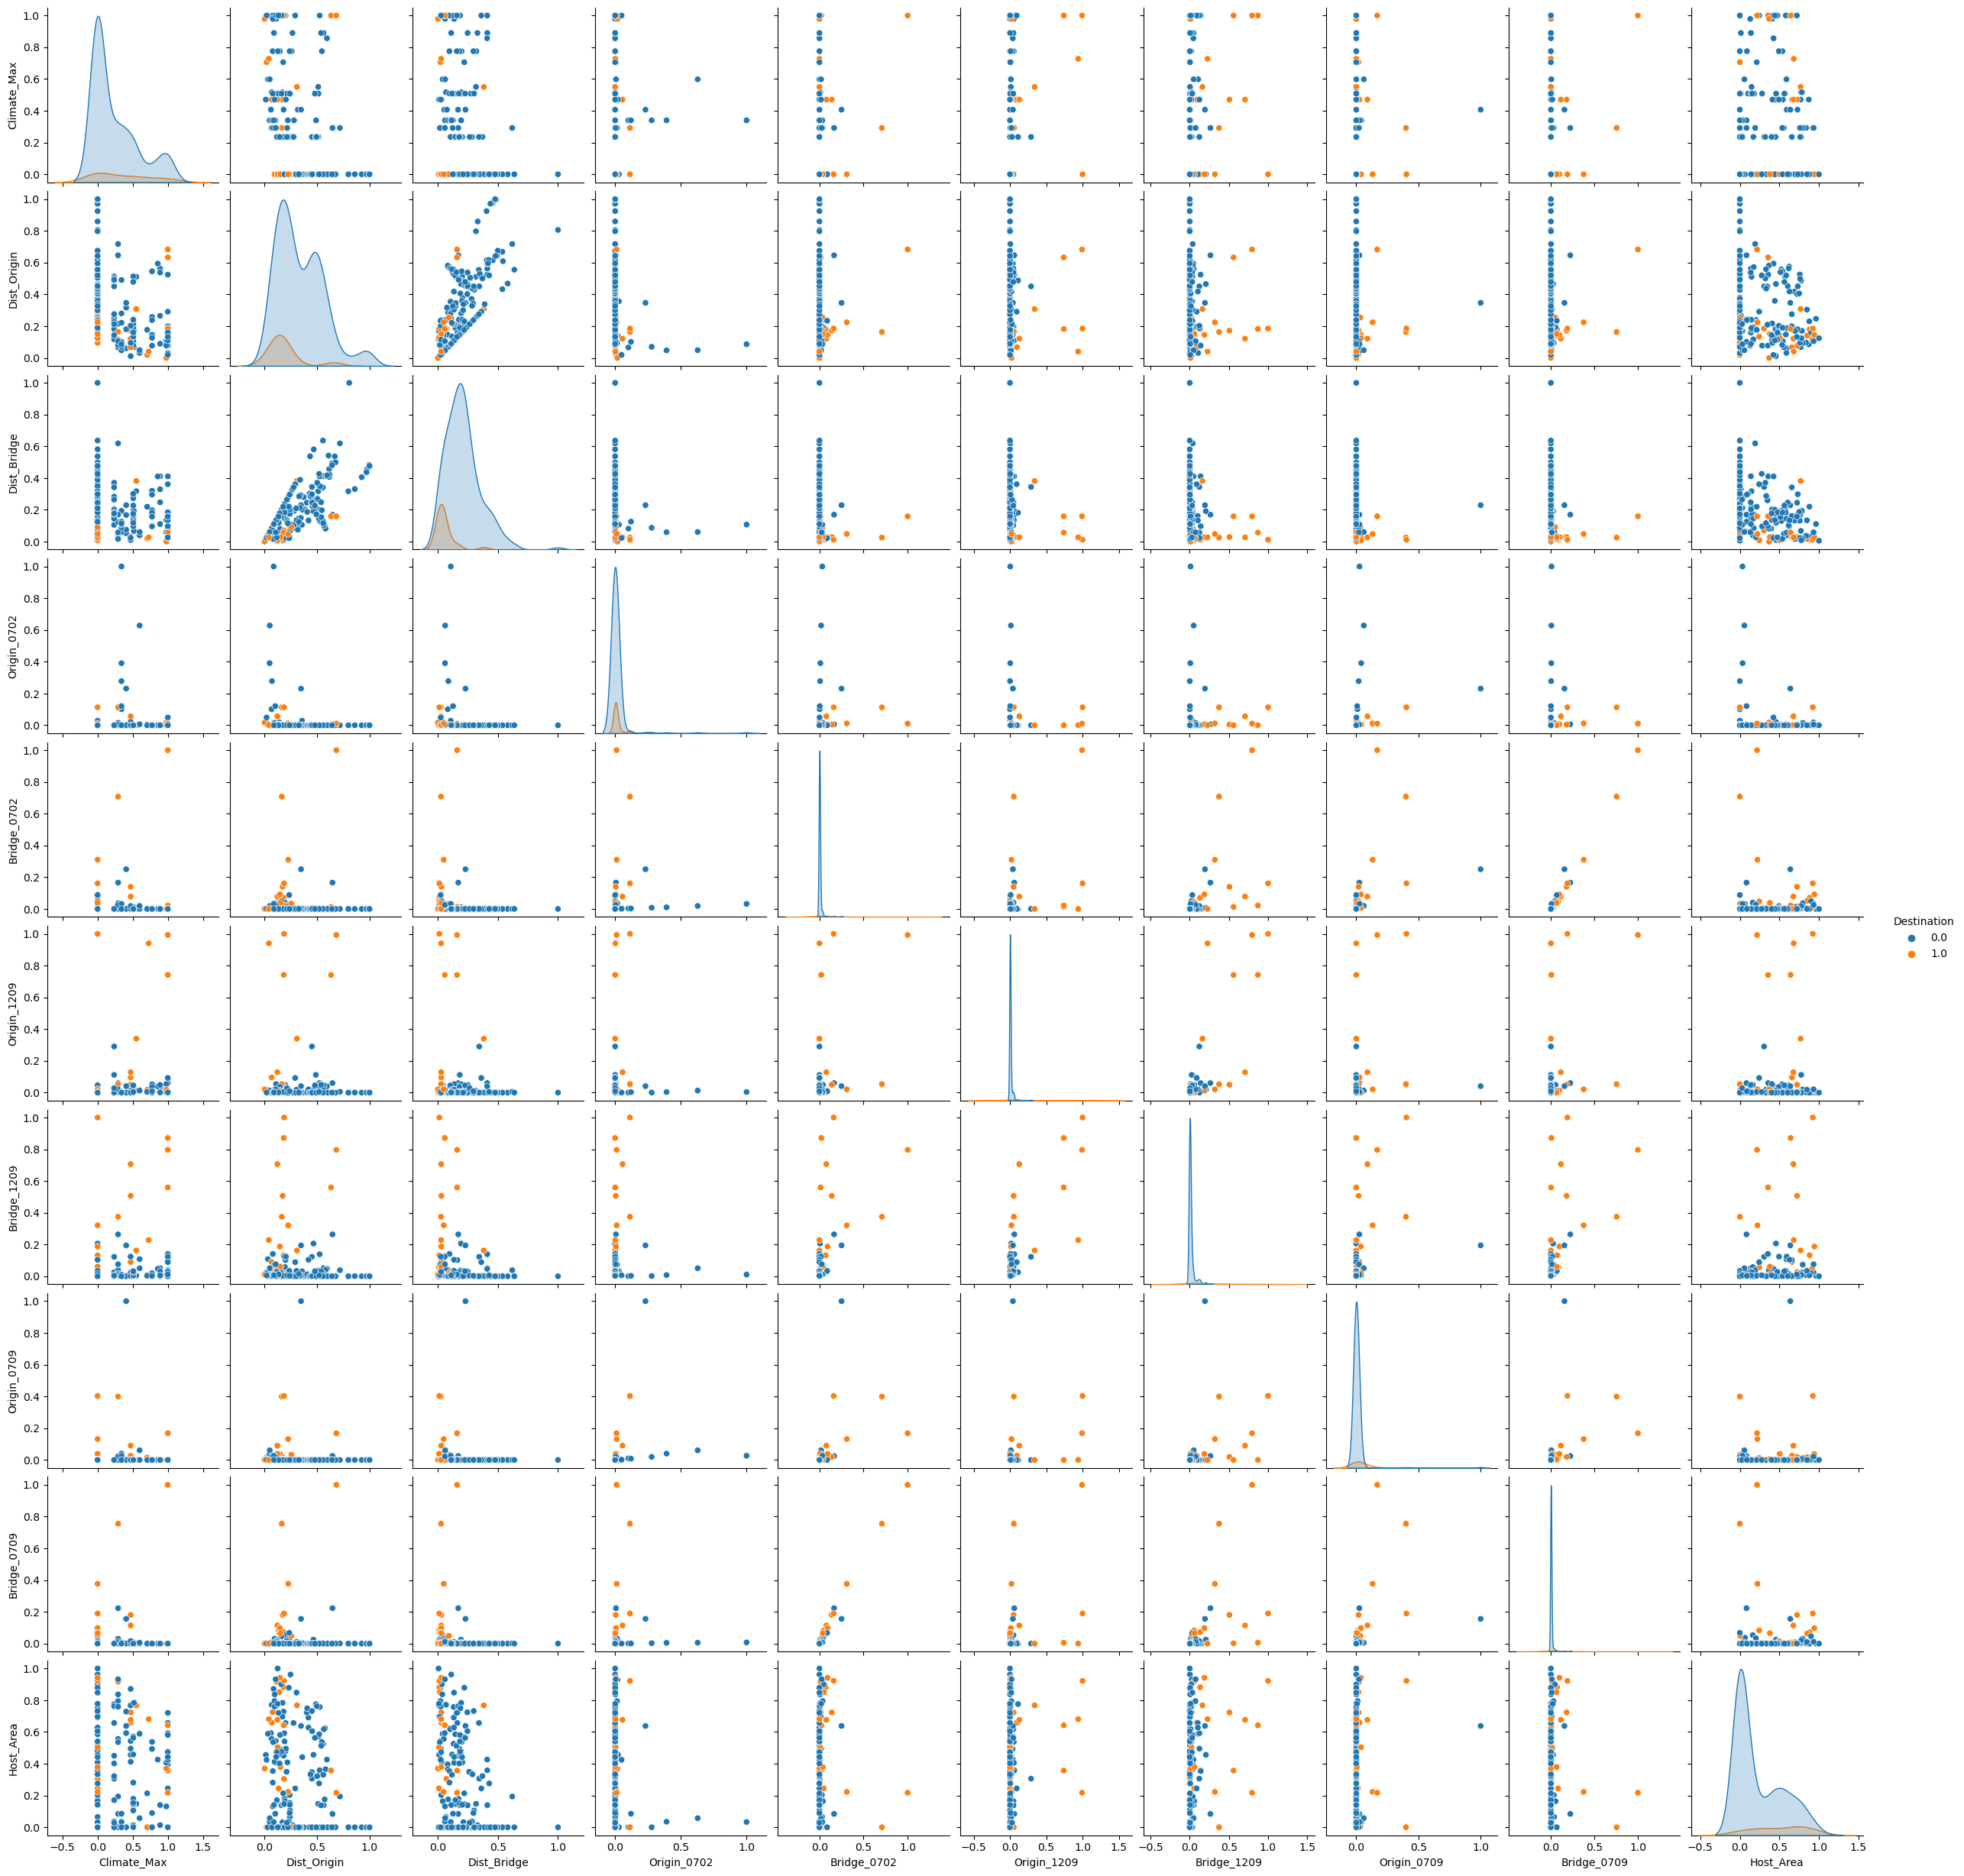

In [4]:
# Visualize the data
sns.pairplot(regression_data, hue = "Destination")
plt.show()


In [ ]:
# Points for interpretation: 
# 
# Do the introduced locations separate clearly from the rest of the data on any of the pathway variables (ie. traded commodities)? (esp. high values)
# Does the relationship appear different with trade from origin vs. bridgeheads?
# Is there a clear relationship with distance? (esp. low values)


In [5]:
# Create the regression formula

predictors = regression_data.loc[:,'Climate_Max':'Host_Area'].columns
predictor_string = ' + '.join(predictors)

print(f'Regression formula: Destination ~ {predictor_string}')

Regression formula: Destination ~ Climate_Max + Dist_Origin + Dist_Bridge + Origin_0702 + Bridge_0702 + Origin_1209 + Bridge_1209 + Origin_0709 + Bridge_0709 + Host_Area


In [6]:
y, X = dmatrices(f'Destination ~ {predictor_string}', data=regression_data, return_type='dataframe')

In [7]:
binomial_model = sm.GLM(y, X, family=sm.families.Binomial())
binomial_results = binomial_model.fit()
print(binomial_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            Destination   No. Observations:                  231
Model:                            GLM   Df Residuals:                      220
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21.893
Date:                Mon, 15 Nov 2021   Deviance:                       43.787
Time:                        09:32:30   Pearson chi2:                     79.5
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.7303      1.542      1.771      

In [ ]:
# Points for interpretation:

# Because the PoPS Global simulation model treats drivers mechanistically, predictors should *positively* correlate with pest introduction, EXCEPT for distance 
# Consider removing commodity pathways with negative values
# Strong negative correlation with distance may suggest a role for natural dispersal
# Highly predictive variables may cause "Perfect separation" error
# 
# Don't interpet too much... there are a lot of variables that may be interacting

## Random Forest approach to the same

In [8]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y.Destination.values, test_size=0.3) 

# Fit the model
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

# Predict to assess accuracy
y_pred=clf.predict(X_test)
print(f"Accuracy score: {metrics.accuracy_score(y_test, y_pred)}; \nReal positives: {y_test.sum()} (Predicted as: {y_pred[y_test==1]}) \nPredicted positives: {y_pred.sum()} (Real values: {y_test[y_pred==1]})")

Accuracy score: 0.9142857142857143; 
Real positives: 8.0 (Predicted as: [0. 1. 1. 1. 0. 1. 0. 1.]) 
Predicted positives: 8.0 (Real values: [1. 0. 0. 1. 0. 1. 1. 1.])


In [9]:
# Assess feature importance
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

Origin_0709    0.191001
Dist_Bridge    0.142668
Bridge_1209    0.129167
Origin_0702    0.122101
Bridge_0709    0.118975
Origin_1209    0.100370
Bridge_0702    0.075934
Dist_Origin    0.055927
Host_Area      0.037561
Climate_Max    0.026296
Intercept      0.000000
dtype: float64

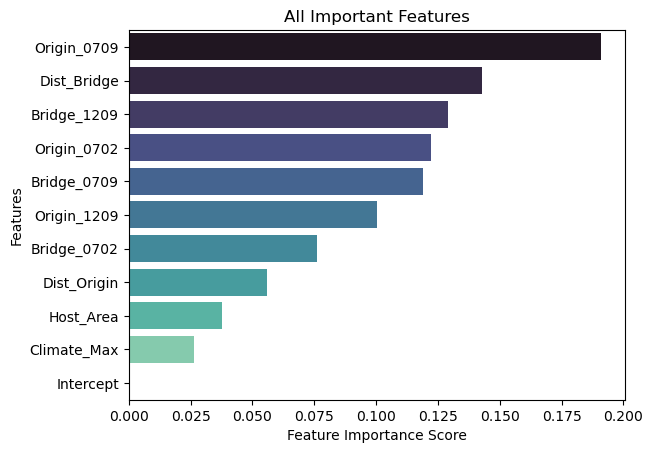

In [10]:
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index, palette="mako")
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("All Important Features")
plt.show()

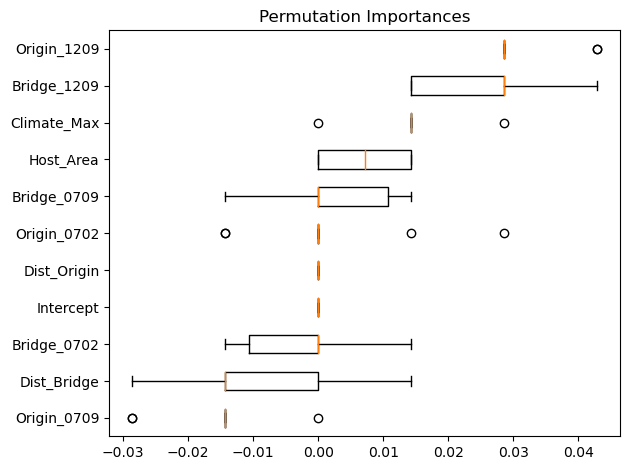

In [11]:
result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx]
)
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

In [ ]:
# Points for interpretation:

# Importance is relevant, BUT, we don't see here if the relationship is positive or negative
# E.g. countries importing tomatoes may be LESS likely to have the virus, because they produce fewer tomatoes

# To help with this, try the RF with only positive predictors below (if you were able to run the binomial regression)



## RF with only positive predictors (from GLM)

In [12]:
positive_predictors = list(binomial_results.params.index[binomial_results.params>0])

# Except for distance which is relevant, if negative
for col in ['Dist_Origin','Dist_Bridge']:
    if binomial_results.params[col] < 0:
        positive_predictors.append(col)

In [13]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X[positive_predictors], y.Destination.values, test_size=0.3) 

# Fit the model
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

# Predict to assess accuracy
y_pred=clf.predict(X_test)
print(f"Accuracy score: {metrics.accuracy_score(y_test, y_pred)}; \nReal positives: {y_test.sum()} (Predicted as: {y_pred[y_test==1]}) \nPredicted positives: {y_pred.sum()} (Real values: {y_test[y_pred==1]})")

Accuracy score: 0.9571428571428572; 
Real positives: 4.0 (Predicted as: [0. 1. 1. 1.]) 
Predicted positives: 5.0 (Real values: [0. 0. 1. 1. 1.])


In [14]:
# Assess feature importance
feature_imp = pd.Series(clf.feature_importances_,index=X[positive_predictors].columns).sort_values(ascending=False)
feature_imp

Bridge_1209    0.230149
Origin_0709    0.185611
Origin_1209    0.184373
Dist_Bridge    0.154578
Bridge_0709    0.134062
Dist_Origin    0.111227
Intercept      0.000000
dtype: float64

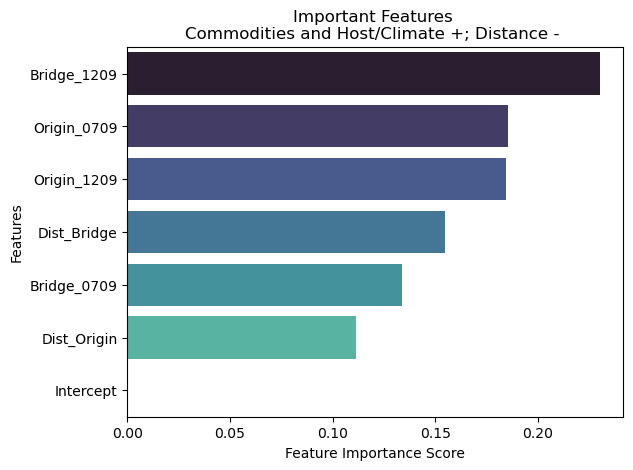

In [15]:
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index, palette="mako")
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Important Features \nCommodities and Host/Climate +; Distance - ")
plt.show()

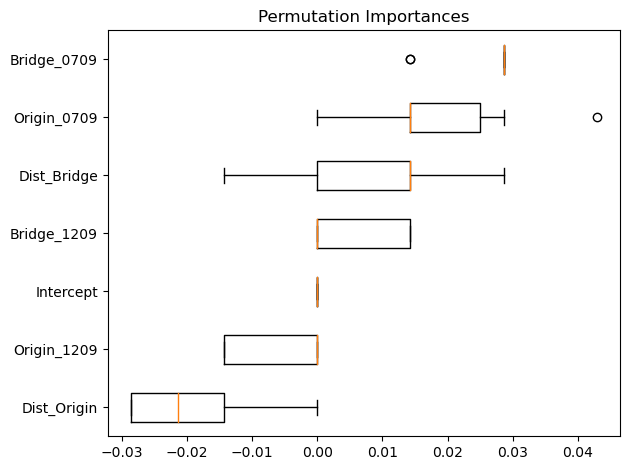

In [17]:
result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx]
)
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

## Up next! 

- Moving to a temporally explicit state-space model (probably in R)